In [1]:
! ls ../data/videos

20200703_手技 ⧸ Te-waza.mp4
20200810_腰技 ⧸ Koshi-waza.mp4
20201026_足技 ⧸ Ashi-waza.mp4
20201116_真捨身技 ⧸ Ma-sutemi-waza.mp4
20210115_横捨身技 ⧸ Yoko-sutemi-waza.mp4
20210329_抑込技 ⧸ Osaekomi-waza.mp4
20210514_絞技 ⧸ Shime-waza.mp4
20210621_関節技 ⧸ Kansetsu-waza.mp4


True


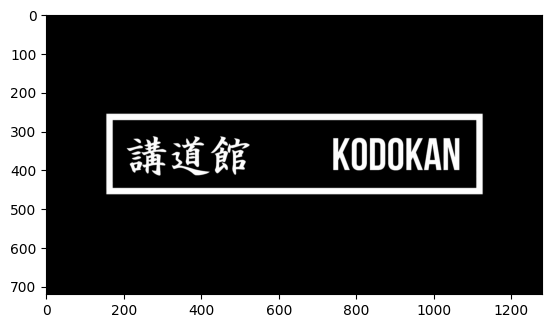

True

In [2]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

videos = list(Path("../data/videos").glob("*.mp4"))
video = videos[0]
# load a video and display it
cap = cv2.VideoCapture(video.as_posix())
# let's skip the first 100 frames
for i in range(100):
    _ = cap.read()

ret, frame = cap.read()
print(ret)
plt.imshow(frame)
plt.show()

# return the stream to the first frame
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

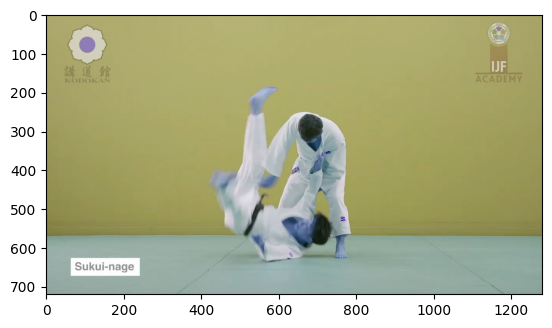

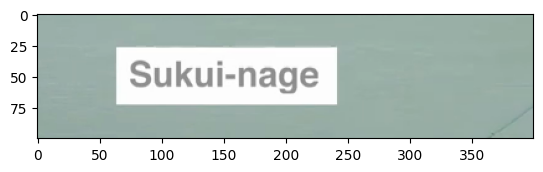

(100, 400, 3)


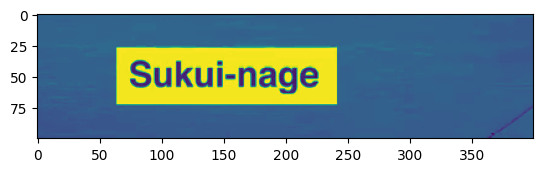

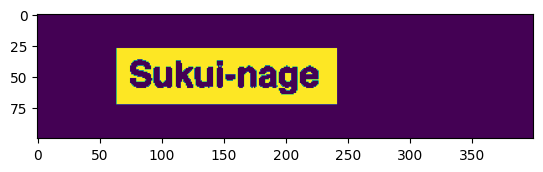

In [3]:
import numpy as np

# lets try to find a frame with throw names in the bottom left

cap.set(cv2.CAP_PROP_POS_FRAMES, 15 * 60)
ret, frame = cap.read()
plt.imshow(frame)
plt.show()

# let's get the bottom left corner
subset = frame[600:700, :400]
plt.imshow(subset)
plt.show()

# how many pixels are pretty close to white?
# 0.9 is pretty close to white
print(subset.shape)

# normalize the pixel distances to be grayscale between 0 and 1
X = cv2.cvtColor(subset, cv2.COLOR_BGR2GRAY)
dist = X / 255
plt.imshow(dist)
plt.show()
# what threshold should we use?
plt.imshow((dist > 0.95).astype(int))
plt.show()

In [4]:
import pytesseract

pytesseract.image_to_string(subset, config="--psm 7")

'| Sukui-nage |\n'

In [5]:
# now lets stream this subset and see if we can calculate discontinuities
# we'll do a simple absolute difference between pixel values
def get_normalized(img):
    subset = img[600:700, :400]
    gray = cv2.cvtColor(subset, cv2.COLOR_BGR2GRAY)
    return gray / 255


diffs = []
prev = None
cap = cv2.VideoCapture(video.as_posix())
while True:
    ret, frame = cap.read()
    if not ret:
        break
    subset = get_normalized(frame)
    if prev is None:
        prev = subset
        continue
    # a simple difference of the current and next frame isn't sufficient here.
    # we'll want to find the box in the frame and match on that
    diff = np.abs((subset > 0.9).astype(int) - (prev > 0.9).astype(int)).sum()
    diffs.append(diff)
    prev = subset

len(diffs)

2179

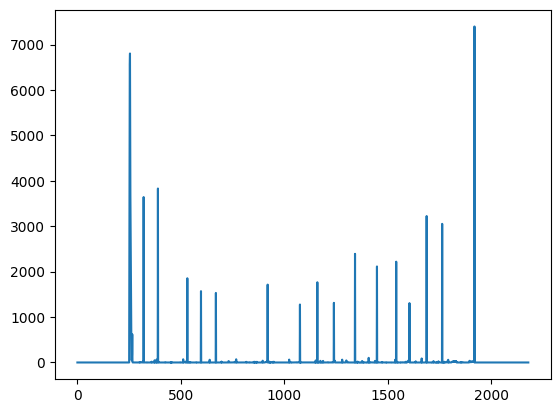

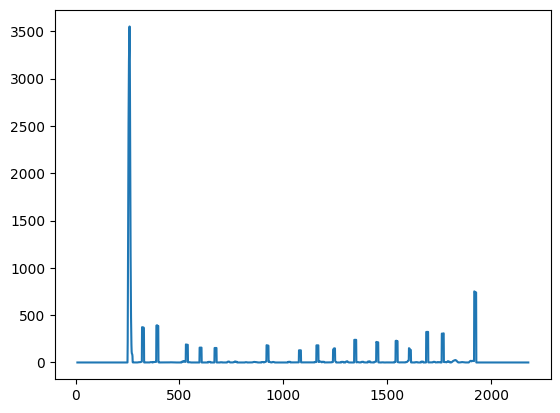

In [6]:
import pandas as pd

plt.plot(diffs)
plt.show()

# rolling sum of the last 10 diffs
plt.plot(pd.Series(diffs).rolling(10).mean())
plt.show()

In [7]:
# find the discontinuities using mean absolute deviation

print(len(diffs), len(pd.Series(diffs).rolling(10).mean()))

2179 2179


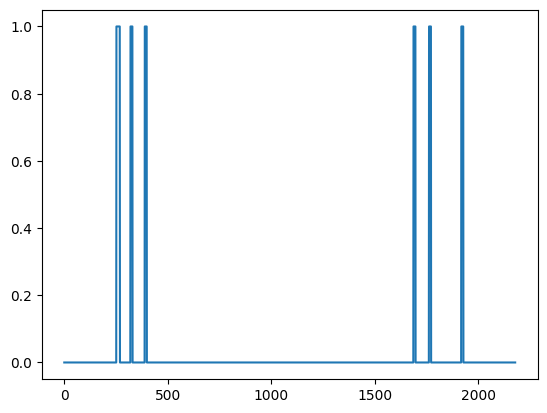

In [8]:
from scipy.stats import median_abs_deviation

y = pd.Series(diffs).rolling(10).mean().fillna(0)
z_scores = (y - y.mean()) / y.std()

plt.plot(z_scores > 1)
plt.show()

In [9]:
# let's try doing this with pytesseract instead of diffs
from tqdm import tqdm


def get_subset(img):
    return img[600:700, :400]


cap = cv2.VideoCapture(video.as_posix())
frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    subset = get_subset(frame)
    frames.append(subset)
len(frames)

2180

In [10]:
# takes approximately 2 minutes to run

# subtitles = []
# for frame in tqdm(frames):
#     text = pytesseract.image_to_string(frame, config="--psm 7", timeout=1)
#     subtitles.append(text)

# from collections import Counter
# Counter(subtitles).most_common(10)

```
100%|██████████| 2180/2180 [02:40<00:00, 13.59it/s]

[('rs\n', 513),
 ('', 434),
 ('Sukui nage\n', 224),
 ('Obi-otoshi\n', 132),
 ('Obi-tori-gaeshi\n', 106),
 ('Ko-uchi-gaeshi\n', 83),
 ('Uki-otoshi\n', 81),
 ('Kibisu-gaeshi\n', 78),
 ('Ippon-seoi-nage\n', 69),
 ('Sumi-otoshi\n', 66)]
```

There are some serious issues with this.
In particular, there are many variations on the spellings.
Instead of using this, I'll try out a different approach based on clustering.

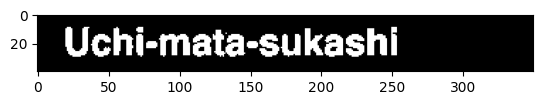

In [30]:
# lets convert each frame to grayscale, then convert it to a binary bitmap
def normalize(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.threshold(img, 255 * 0.9, 255, cv2.THRESH_BINARY)[1]
    # lets also flood fill the background with white starting at the bottom left
    cv2.floodFill(img, None, (0, 0), 255)
    # truncate again
    img = img[30:70, 50:400]
    # # now downscale the image a bit to make it easier to work with
    # img = cv2.resize(img, (0,0), fx=0.75, fy=0.75)
    # # binarize again
    # img = cv2.threshold(img, 255*0.9, 255, cv2.THRESH_BINARY)[1]
    # invert so text is 255
    img = cv2.bitwise_not(img)
    return img


bin_frames = [normalize(frame) for frame in frames]
plt.imshow(bin_frames[1700], cmap="gray")
plt.show()

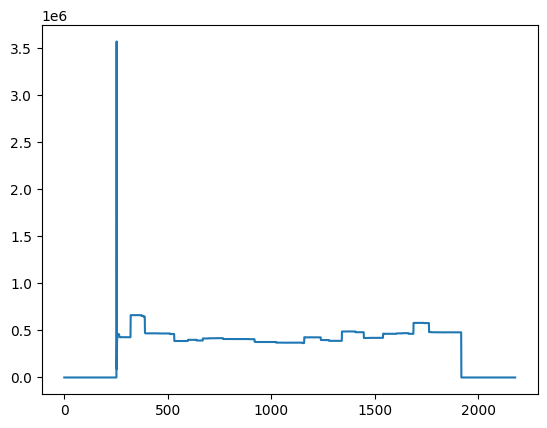

253 1918


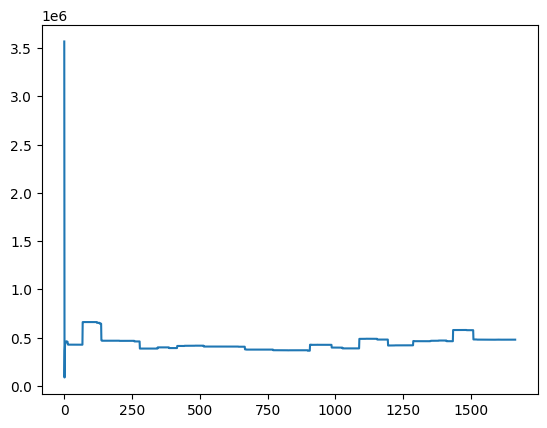

In [31]:
# find the positions of all the 0s
y = np.array(bin_frames).sum(axis=2).sum(axis=1)
plt.plot(y)
plt.show()

# find the first non-zero and last non-zero indices
start = np.where(y > 0)[0][0]
end = np.where(y > 0)[0][-1]
print(start, end)
plt.plot(y[start:end])

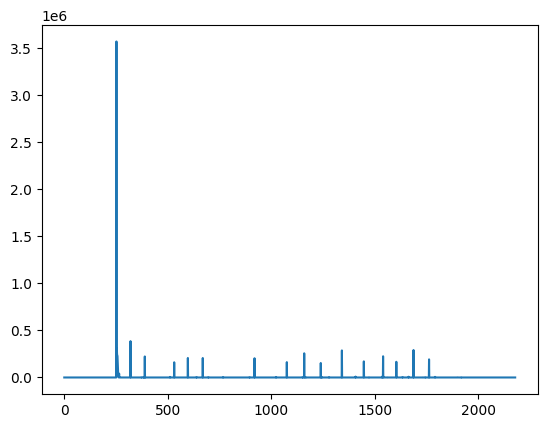

In [45]:
# let's calculate diffs using this cleaner version of the subtitles
prev = None
diffs = []
X = bin_frames
for i in range(1, len(X)):
    diffs.append(np.sum(np.abs(X[i] - X[i - 1])))

plt.plot(diffs)
plt.show()

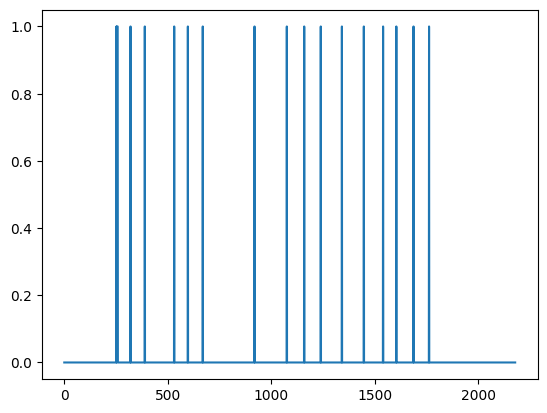

In [50]:
y = np.array(diffs)
scores = (y - np.mean(y)) / y.std()
plt.plot(scores > 1.5)
plt.show()

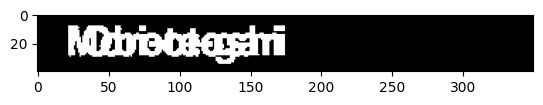

In [33]:
plt.imshow(np.bitwise_or(bin_frames[1000], bin_frames[1501]), cmap="gray")

In [34]:
np.arange(10)[:3]

array([0, 1, 2])

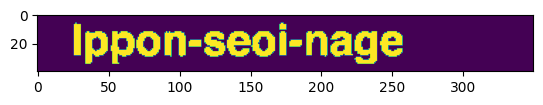

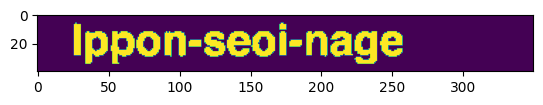

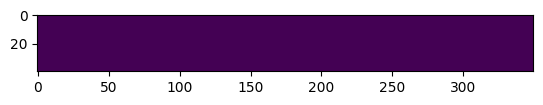

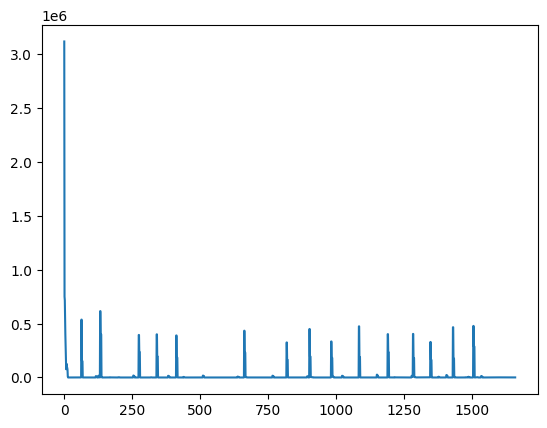

In [37]:
from functools import reduce

# let's calculate diffs using xor

rows = bin_frames[start:end]
k = 5
diffs = []
for i in range(k, len(rows)):
    cur = rows[i]
    # bitwise or the previous k rows
    prev = reduce(np.bitwise_or, rows[i - k : i - 1])
    if i == 120:
        plt.imshow(prev)
        plt.show()
        plt.imshow(cur)
        plt.show()
        plt.imshow(np.bitwise_xor(prev, cur))
        plt.show()
    # the difference should be relatively small
    diffs.append(np.bitwise_xor(prev, cur).sum())

plt.plot(diffs)
plt.show()

(1665, 40, 350)
(1665, 14000)
CPU times: user 32.6 s, sys: 1.21 s, total: 33.8 s
Wall time: 4.91 s


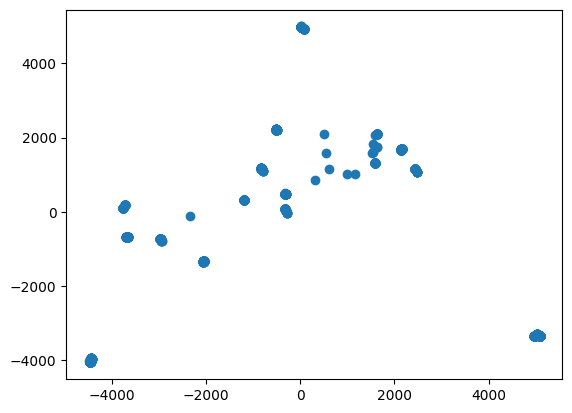

In [17]:
# lets plot this using pca
from sklearn.decomposition import PCA

X = np.array(bin_frames[start:end])
print(X.shape)
X = X.reshape((X.shape[0], -1))
print(X.shape)

pca = PCA(n_components=2)
%time pca.fit(X)
g = pca.transform(X)

plt.scatter(g[:, 0], g[:, 1])
plt.show()

/Users/anthony/code/personal/judo/.venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/anthony/code/personal/judo/.venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/anthony/code/personal/judo/.venv/lib/python3.10/site-

UMAP( verbose=1)
Fri Aug 18 21:36:14 2023 Construct fuzzy simplicial set
Fri Aug 18 21:36:20 2023 Finding Nearest Neighbors
Fri Aug 18 21:36:21 2023 Finished Nearest Neighbor Search
Fri Aug 18 21:36:22 2023 Construct embedding


/Users/anthony/code/personal/judo/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
Epochs completed: 100%| ██████████ 500/500 [00:02]


Fri Aug 18 21:36:24 2023 Finished embedding
CPU times: user 16.5 s, sys: 295 ms, total: 16.8 s
Wall time: 10.6 s


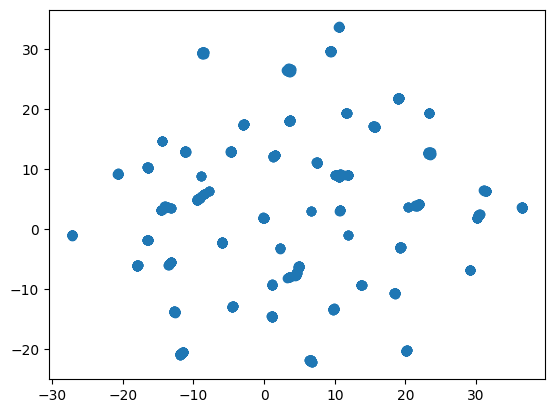

In [18]:
from umap import UMAP

umap = UMAP(n_components=2, verbose=1)
%time g = umap.fit_transform(X)

plt.scatter(g[:, 0], g[:, 1])

In [19]:
np.linalg.norm(g[10] - g[5:10], axis=1)

array([14.471901  ,  0.5066301 ,  0.5206703 ,  0.05581211,  0.06434986],
      dtype=float32)

UMAP(n_components=32, verbose=1)
Fri Aug 18 21:36:25 2023 Construct fuzzy simplicial set
Fri Aug 18 21:36:30 2023 Finding Nearest Neighbors
Fri Aug 18 21:36:30 2023 Finished Nearest Neighbor Search
Fri Aug 18 21:36:30 2023 Construct embedding


Epochs completed: 100%| ██████████ 500/500 [00:02]


Fri Aug 18 21:36:33 2023 Finished embedding
CPU times: user 19.6 s, sys: 838 ms, total: 20.5 s
Wall time: 8.88 s


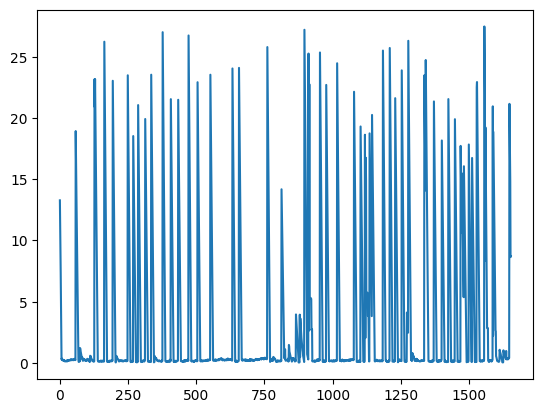

In [20]:
# now lets the try the previous diffing method, but with l2 norm
umap = UMAP(n_components=32, verbose=1)
%time g = umap.fit_transform(X)

diffs = []
k = 10
for i in range(k, len(g)):
    # let's find the average difference between the last 3 items
    score = np.linalg.norm(g[i] - g[i - k : i], axis=1).mean()
    diffs.append(score)
plt.plot(diffs)

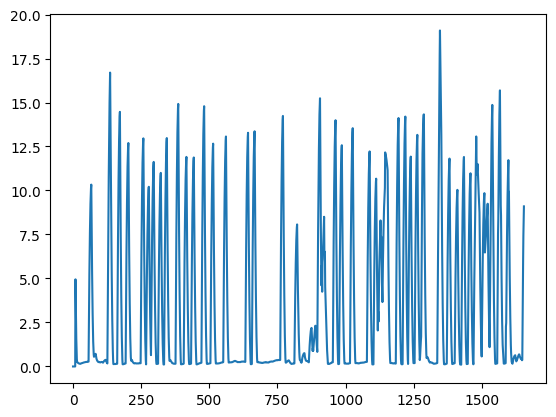

In [21]:
# rolling mean
s = pd.Series(diffs).rolling(10).mean().fillna(0)
plt.plot(s)